# 6. Deep Analysis: Error Investigation & Feature Importance

## Pipeline Context

This notebook is **Part 6** of the gRNA classification pipeline:

1. `1_data_exploration.ipynb` - Initial data exploration
2. `2_data_preparation_v4.ipynb` - Feature extraction and data preparation
3. `3_model_training_v4.ipynb` - Model training and selection → **XGBoost selected**
4. `4_model_interpretation_v4.ipynb` - SHAP analysis
5. `5_feature_structure_mapping.ipynb` - Biological feature mapping
6. **This notebook** - Deep error analysis

## Key Information from Training (Notebook 3 v4)

- **Selected Model**: XGBoost (tuned)
- **Best Parameters**: `learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.8`
- **Test Performance**: Accuracy=95.5%, F1=95.7%, AUC=98.6%
- **Errors**: FP=8, FN=8

## This Notebook

- **LOADS the trained model** (does NOT retrain!)
- Detailed False Positive analysis
- Detailed False Negative analysis  
- MDI vs Permutation importance comparison
- Correlation analysis of top features

---

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

import warnings
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import joblib

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12, 8)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports complete")

Imports complete


In [2]:
# =============================================================================
# SETUP PATHS
# =============================================================================

# Try multiple possible locations
POSSIBLE_BASE_DIRS = [
    Path.home() / 'projects' / 'grna-inspector',
    Path('/mnt/user-data/uploads'),
    Path('.')
]

BASE_DIR = None
for path in POSSIBLE_BASE_DIRS:
    # Check for data in either structure
    if (path / 'data' / 'processed' / 'v4_pipeline' / 'train_data.csv').exists():
        BASE_DIR = path
        DATA_DIR = path / 'data' / 'processed' / 'v4_pipeline'
        MODELS_DIR = path / 'models'
        break
    elif (path / 'train_data.csv').exists():
        BASE_DIR = path
        DATA_DIR = path
        MODELS_DIR = path
        break

if BASE_DIR is None:
    raise FileNotFoundError("Could not find data files")

OUTPUT_DIR = DATA_DIR / 'deep_analysis'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Base directory: /Users/anna/projects/grna-inspector
Data directory: /Users/anna/projects/grna-inspector/data/processed/v4_pipeline
Models directory: /Users/anna/projects/grna-inspector/models
Output directory: /Users/anna/projects/grna-inspector/data/processed/v4_pipeline/deep_analysis


In [3]:
# =============================================================================
# LOAD DATA
# =============================================================================

print("="*70)
print("LOADING DATA")
print("="*70)

train_df = pd.read_csv(DATA_DIR / 'train_data.csv')
test_df = pd.read_csv(DATA_DIR / 'test_data.csv')

# Load feature names
feature_file = DATA_DIR / 'feature_names.txt'
if feature_file.exists():
    with open(feature_file, 'r') as f:
        feature_names = [line.strip() for line in f if line.strip()]
else:
    # Fallback: infer from data
    exclude_cols = ['sequence_id', 'sequence', 'length', 'label', 'source']
    feature_names = [c for c in train_df.columns if c not in exclude_cols]

print(f"\n✓ Train samples: {len(train_df)}")
print(f"✓ Test samples: {len(test_df)}")
print(f"✓ Features: {len(feature_names)}")
print(f"✓ Sequences available: {'sequence' in test_df.columns}")

LOADING DATA

✓ Train samples: 1618
✓ Test samples: 354
✓ Features: 127
✓ Sequences available: True


In [4]:
# =============================================================================
# LOAD TRAINED MODEL (from Notebook 3)
# =============================================================================

print("="*70)
print("LOADING TRAINED MODEL")
print("="*70)

# Find model file
model_files = list(MODELS_DIR.glob('grna_classifier_*.joblib'))

if model_files:
    model_path = model_files[0]
    model = joblib.load(model_path)
    model_name = model_path.stem.replace('grna_classifier_', '').replace('_', ' ').title()
    print(f"\n✓ Model loaded: {model_path.name}")
    print(f"  Type: {type(model).__name__}")
else:
    raise FileNotFoundError(
        "Model file not found!\n"
        "Please run notebook 3_model_training_v4.ipynb first to train and save the model."
    )

# Load metadata if available
metadata_path = MODELS_DIR / 'model_metadata.json'
if metadata_path.exists():
    with open(metadata_path) as f:
        metadata = json.load(f)
    print(f"\n✓ Metadata loaded")
    print(f"  Training date: {metadata.get('training_date', 'N/A')}")
    if 'best_params' in metadata:
        print(f"  Best params: {metadata['best_params']}")
else:
    metadata = {}
    print("\n⚠ Metadata not found")

LOADING TRAINED MODEL

✓ Model loaded: grna_classifier_xgboost.joblib
  Type: XGBClassifier

✓ Metadata loaded
  Training date: 2025-12-15T16:23:03.045693
  Best params: {'learning_rate': 0.15, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


In [5]:
# =============================================================================
# GENERATE PREDICTIONS (using loaded model)
# =============================================================================

print("="*70)
print("GENERATING PREDICTIONS")
print("="*70)

X_train = train_df[feature_names].values
y_train = train_df['label'].values
X_test = test_df[feature_names].values
y_test = test_df['label'].values

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Add to dataframe
test_df['predicted'] = y_pred
test_df['probability'] = y_prob

# Classify predictions
def get_prediction_type(row):
    if row['label'] == 1 and row['predicted'] == 1:
        return 'True Positive'
    elif row['label'] == 0 and row['predicted'] == 0:
        return 'True Negative'
    elif row['label'] == 0 and row['predicted'] == 1:
        return 'False Positive'
    else:
        return 'False Negative'

test_df['prediction_type'] = test_df.apply(get_prediction_type, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"  TN={tn:4d}  FP={fp:4d}")
print(f"  FN={fn:4d}  TP={tp:4d}")

print(f"\nPrediction Type Distribution:")
for ptype, count in test_df['prediction_type'].value_counts().items():
    pct = count / len(test_df) * 100
    print(f"  {ptype}: {count} ({pct:.1f}%)")

# Verify against expected (from notebook 3)
print(f"\n{'─'*50}")
print("Verification (should match Notebook 3):")
print(f"  Expected: TN=162, FP=8, FN=8, TP=176")
print(f"  Got:      TN={tn}, FP={fp}, FN={fn}, TP={tp}")
if tn == 162 and fp == 8 and fn == 8 and tp == 176:
    print("  ✓ MATCH!")
else:
    print("  ⚠ MISMATCH - check model file!")

GENERATING PREDICTIONS

Confusion Matrix:
  TN= 162  FP=   8
  FN=   8  TP= 176

Prediction Type Distribution:
  True Positive: 176 (49.7%)
  True Negative: 162 (45.8%)
  False Negative: 8 (2.3%)
  False Positive: 8 (2.3%)

──────────────────────────────────────────────────
Verification (should match Notebook 3):
  Expected: TN=162, FP=8, FN=8, TP=176
  Got:      TN=162, FP=8, FN=8, TP=176
  ✓ MATCH!


In [6]:
# =============================================================================
# CREATE SUBSETS
# =============================================================================

tp_df = test_df[test_df['prediction_type'] == 'True Positive'].copy()
tn_df = test_df[test_df['prediction_type'] == 'True Negative'].copy()
fp_df = test_df[test_df['prediction_type'] == 'False Positive'].copy()
fn_df = test_df[test_df['prediction_type'] == 'False Negative'].copy()

print(f"Subsets created:")
print(f"  True Positives:  {len(tp_df)}")
print(f"  True Negatives:  {len(tn_df)}")
print(f"  False Positives: {len(fp_df)}")
print(f"  False Negatives: {len(fn_df)}")

Subsets created:
  True Positives:  176
  True Negatives:  162
  False Positives: 8
  False Negatives: 8


In [7]:
# =============================================================================
# FALSE POSITIVES ANALYSIS
# =============================================================================

print("="*70)
print("FALSE POSITIVES ANALYSIS")
print("Non-gRNA sequences incorrectly classified as gRNA")
print("="*70)

print(f"\nTotal False Positives: {len(fp_df)}")

# Source distribution
if 'source' in fp_df.columns:
    print("\n1. Source Distribution:")
    print("-" * 40)
    for source, count in fp_df['source'].value_counts().items():
        pct = count / len(fp_df) * 100
        print(f"   {source}: {count} ({pct:.1f}%)")
    
    print("\n   Interpretation:")
    if 'minicircle_nonGRNA' not in fp_df['source'].values:
        print("   → No FP from real minicircle regions (good!)")
    print("   → FP are from synthetic (random/chimeric) sequences")

# Confidence distribution
print("\n2. Model Confidence on FP:")
print("-" * 40)
print(f"   Probability range: {fp_df['probability'].min():.3f} - {fp_df['probability'].max():.3f}")
print(f"   Mean probability:  {fp_df['probability'].mean():.3f}")
print(f"   Median:            {fp_df['probability'].median():.3f}")

high_conf = (fp_df['probability'] > 0.8).sum()
print(f"\n   High-confidence errors (prob > 0.8): {high_conf}")
if high_conf > 0:
    print("   ⚠ These require careful investigation!")

FALSE POSITIVES ANALYSIS
Non-gRNA sequences incorrectly classified as gRNA

Total False Positives: 8

1. Source Distribution:
----------------------------------------
   random: 5 (62.5%)
   chimeric: 2 (25.0%)
   minicircle: 1 (12.5%)

   Interpretation:
   → No FP from real minicircle regions (good!)
   → FP are from synthetic (random/chimeric) sequences

2. Model Confidence on FP:
----------------------------------------
   Probability range: 0.727 - 0.999
   Mean probability:  0.874
   Median:            0.869

   High-confidence errors (prob > 0.8): 4
   ⚠ These require careful investigation!


In [8]:
# =============================================================================
# FEATURE COMPARISON: FP vs TP vs TN
# =============================================================================

print("\n" + "="*70)
print("FEATURE COMPARISON: Why do FP look like gRNA?")
print("="*70)

# Key biological features to analyze
key_features = [
    'anchor_AC_content', 'anchor_C_freq', 'anchor_G_freq', 'anchor_G_depleted',
    'init_has_AWAHH', 'init_has_AAAA', 'init_4_A_count', 'init_starts_A',
    'guide_A_freq', 'guide_A_elevated', 'guide_purine_freq',
    'ends_with_T', 'last3_T_count', 'last5_T_freq',
    'max_homopolymer', 'complexity_ratio', 'entropy',
    'global_A_freq', 'global_T_freq',
    'dinuc_TT_freq', 'dinuc_AC_freq',
    'grna_signature_count'
]
key_features = [f for f in key_features if f in feature_names]

print(f"\nAnalyzing {len(key_features)} key biological features:\n")
print(f"{'Feature':<25} {'TP (gRNA)':<12} {'TN (non)':<12} {'FP':<14} {'FP closer to'}")
print("-" * 80)

fp_like_grna = 0
comparison_data = []

for feat in key_features:
    tp_mean = tp_df[feat].mean()
    tn_mean = tn_df[feat].mean()
    fp_mean = fp_df[feat].mean()
    
    # Determine which class FP resembles more
    dist_to_tp = abs(fp_mean - tp_mean)
    dist_to_tn = abs(fp_mean - tn_mean)
    closer = 'gRNA (TP)' if dist_to_tp < dist_to_tn else 'non-gRNA (TN)'
    
    if 'gRNA' in closer:
        fp_like_grna += 1
    
    print(f"{feat:<25} {tp_mean:<12.4f} {tn_mean:<12.4f} {fp_mean:<14.4f} {closer}")
    
    comparison_data.append({
        'feature': feat,
        'TP_mean': tp_mean,
        'TN_mean': tn_mean,
        'FP_mean': fp_mean,
        'FP_closer_to': closer
    })

print("-" * 80)
print(f"\nSummary: {fp_like_grna}/{len(key_features)} features where FP resemble gRNA")

# Save comparison
comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv(OUTPUT_DIR / 'feature_comparison_fp_tp_tn.csv', index=False)


FEATURE COMPARISON: Why do FP look like gRNA?

Analyzing 22 key biological features:

Feature                   TP (gRNA)    TN (non)     FP             FP closer to
--------------------------------------------------------------------------------
anchor_AC_content         0.8196       0.6145       0.8276         gRNA (TP)
anchor_C_freq             0.2308       0.0854       0.3001         gRNA (TP)
anchor_G_freq             0.0538       0.1010       0.0764         gRNA (TP)
anchor_G_depleted         0.8523       0.6667       0.7500         non-gRNA (TN)
init_has_AWAHH            0.3239       0.0247       0.3750         gRNA (TP)
init_has_AAAA             0.0909       0.0123       0.1250         gRNA (TP)
init_4_A_count            2.5170       1.4938       3.0000         gRNA (TP)
init_starts_A             0.7955       0.3889       0.7500         gRNA (TP)
guide_A_freq              0.4079       0.3810       0.4095         gRNA (TP)
guide_A_elevated          0.5284       0.4136       0.5

In [9]:
# =============================================================================
# DETAILED ANALYSIS OF EACH FALSE POSITIVE
# =============================================================================

print("\n" + "="*70)
print("DETAILED ANALYSIS OF EACH FALSE POSITIVE")
print("="*70)

# Features to analyze per FP
analysis_features = [
    'anchor_AC_content', 'anchor_C_freq', 'init_4_A_count',
    'init_has_AWAHH', 'dinuc_TT_freq', 'grna_signature_count'
]
analysis_features = [f for f in analysis_features if f in feature_names]

for i, (idx, row) in enumerate(fp_df.iterrows()):
    print(f"\n{'─'*60}")
    print(f"FALSE POSITIVE #{i+1}")
    print(f"{'─'*60}")
    
    print(f"ID: {row.get('sequence_id', idx)}")
    if 'source' in row:
        print(f"Source: {row['source']}")
    print(f"Model probability: {row['probability']:.3f} ({row['probability']*100:.0f}% confident it's gRNA)")
    
    if 'sequence' in row and pd.notna(row['sequence']):
        seq = row['sequence']
        print(f"Sequence length: {len(seq)} nt")
        print(f"Sequence: {seq}")
    
    print(f"\nKey feature values (compared to typical gRNA):")
    grna_like_count = 0
    for feat in analysis_features:
        val = row[feat]
        tp_mean = tp_df[feat].mean()
        tn_mean = tn_df[feat].mean()
        
        is_grna_like = abs(val - tp_mean) < abs(val - tn_mean)
        marker = 'gRNA-like' if is_grna_like else 'non-gRNA'
        if is_grna_like:
            grna_like_count += 1
        
        print(f"  {feat:<24}: {val:.3f} (TP:{tp_mean:.3f}, TN:{tn_mean:.3f}) -> {marker}")
    
    print(f"\n  Score: {grna_like_count}/{len(analysis_features)} features gRNA-like")
    if grna_like_count >= len(analysis_features) // 2:
        print(f"  CONCLUSION: This sequence genuinely resembles gRNA in multiple features!")


DETAILED ANALYSIS OF EACH FALSE POSITIVE

────────────────────────────────────────────────────────────
FALSE POSITIVE #1
────────────────────────────────────────────────────────────
ID: mO_270_nonGRNA_622_672
Source: minicircle
Model probability: 0.999 (100% confident it's gRNA)
Sequence length: 50 nt
Sequence: ATAAAACACCAAACGTGAATTGTATCATATAGACTGTGTGAGAATTATTG

Key feature values (compared to typical gRNA):
  anchor_AC_content       : 1.000 (TP:0.820, TN:0.614) -> gRNA-like
  anchor_C_freq           : 0.500 (TP:0.231, TN:0.085) -> gRNA-like
  init_4_A_count          : 3.000 (TP:2.517, TN:1.494) -> gRNA-like
  init_has_AWAHH          : 1.000 (TP:0.324, TN:0.025) -> gRNA-like
  dinuc_TT_freq           : 0.061 (TP:0.036, TN:0.120) -> gRNA-like
  grna_signature_count    : 3.000 (TP:3.114, TN:2.006) -> gRNA-like

  Score: 6/6 features gRNA-like
  CONCLUSION: This sequence genuinely resembles gRNA in multiple features!

────────────────────────────────────────────────────────────
FALSE POS

In [10]:
# =============================================================================
# FALSE NEGATIVES ANALYSIS
# =============================================================================

print("\n" + "="*70)
print("FALSE NEGATIVES ANALYSIS")
print("True gRNA sequences missed by the classifier")
print("="*70)

print(f"\nTotal False Negatives: {len(fn_df)}")

print("\n1. Model Confidence on FN:")
print("-" * 40)
print(f"   Probability range: {fn_df['probability'].min():.3f} - {fn_df['probability'].max():.3f}")
print(f"   Mean probability:  {fn_df['probability'].mean():.3f}")
print(f"   Note: Low probability means model confidently rejected these as gRNA")

print("\n2. Feature Comparison: FN vs Typical gRNA (TP):")
print("-" * 60)
print(f"{'Feature':<25} {'FN mean':<12} {'TP mean':<12} {'Difference'}")
print("-" * 60)

for feat in analysis_features:
    fn_mean = fn_df[feat].mean()
    tp_mean = tp_df[feat].mean()
    diff = fn_mean - tp_mean
    arrow = '↓' if diff < -0.1 else '↑' if diff > 0.1 else '~'
    print(f"{feat:<25} {fn_mean:<12.4f} {tp_mean:<12.4f} {diff:+.4f} {arrow}")

print("\n   Interpretation:")
print("   ↓ = FN has LOWER value than typical gRNA (weakened signal)")
print("   These may be atypical or non-canonical gRNAs")


FALSE NEGATIVES ANALYSIS
True gRNA sequences missed by the classifier

Total False Negatives: 8

1. Model Confidence on FN:
----------------------------------------
   Probability range: 0.066 - 0.493
   Mean probability:  0.300
   Note: Low probability means model confidently rejected these as gRNA

2. Feature Comparison: FN vs Typical gRNA (TP):
------------------------------------------------------------
Feature                   FN mean      TP mean      Difference
------------------------------------------------------------
anchor_AC_content         0.5469       0.8196       -0.2728 ↓
anchor_C_freq             0.1140       0.2308       -0.1169 ↓
init_4_A_count            2.0000       2.5170       -0.5170 ↓
init_has_AWAHH            0.1250       0.3239       -0.1989 ↓
dinuc_TT_freq             0.0740       0.0360       +0.0380 ~
grna_signature_count      1.6250       3.1136       -1.4886 ↓

   Interpretation:
   ↓ = FN has LOWER value than typical gRNA (weakened signal)
   These m

In [11]:
# =============================================================================
# FEATURE IMPORTANCE: MDI vs PERMUTATION
# =============================================================================

print("\n" + "="*70)
print("FEATURE IMPORTANCE COMPARISON: MDI vs Permutation")
print("="*70)

# MDI importance (from model)
if hasattr(model, 'feature_importances_'):
    mdi_importance = model.feature_importances_
else:
    print("Model doesn't have feature_importances_, using saved importance")
    imp_file = MODELS_DIR / 'feature_importance.csv'
    if imp_file.exists():
        mdi_df = pd.read_csv(imp_file)
        mdi_importance = mdi_df.set_index('feature')['importance'].reindex(feature_names).values
    else:
        mdi_importance = np.zeros(len(feature_names))

# Permutation importance
print("\nCalculating permutation importance (this may take a moment)...")
perm_result = permutation_importance(
    model, X_test, y_test, 
    n_repeats=10, 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
perm_importance = perm_result.importances_mean

# Create comparison DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'mdi': mdi_importance,
    'permutation': perm_importance
})

importance_df['mdi_rank'] = importance_df['mdi'].rank(ascending=False).astype(int)
importance_df['perm_rank'] = importance_df['permutation'].rank(ascending=False).astype(int)
importance_df['rank_diff'] = importance_df['perm_rank'] - importance_df['mdi_rank']

# Display top 20
print("\nTop 20 Features by MDI:")
print("-" * 85)
print(f"{'Feature':<30} {'MDI':<10} {'Perm':<10} {'MDI Rank':<10} {'Perm Rank':<10} {'Diff'}")
print("-" * 85)

for _, row in importance_df.nlargest(20, 'mdi').iterrows():
    diff_str = f"+{int(row['rank_diff'])}" if row['rank_diff'] > 0 else str(int(row['rank_diff']))
    print(f"{row['feature']:<30} {row['mdi']:<10.4f} {row['permutation']:<10.4f} {int(row['mdi_rank']):<10} {int(row['perm_rank']):<10} {diff_str}")


FEATURE IMPORTANCE COMPARISON: MDI vs Permutation

Calculating permutation importance (this may take a moment)...

Top 20 Features by MDI:
-------------------------------------------------------------------------------------
Feature                        MDI        Perm       MDI Rank   Perm Rank  Diff
-------------------------------------------------------------------------------------
anchor_C_freq                  0.1453     0.0059     1          9          +8
init_4_A_count                 0.0659     0.0056     2          12         +10
anchor_AC_content              0.0630     0.0031     3          20         +17
global_GC_content              0.0362     -0.0017    4          106        +102
grna_signature_count           0.0264     -0.0073    5          127        +122
max_homopolymer                0.0262     0.0124     6          3          -3
guide_C_count                  0.0256     0.0059     7          10         +3
first_A_pos_rel                0.0251     -0.0031    8  

In [12]:
# =============================================================================
# IMPORTANCE BY gRNA REGION
# =============================================================================

print("\n" + "="*70)
print("IMPORTANCE BY gRNA REGION")
print("="*70)

# Define regions
region_prefixes = {
    'Initiation': ['init_'],
    'Anchor': ['anchor_'],
    'Guiding': ['guide_'],
    'Terminal': ['ends_', 'last3_', 'last5_', 'last_'],
    'Structure': ['max_homopolymer', 'n_homopolymers', 'complexity', 'entropy', 'palindrome'],
    'Composition': ['global_', 'dinuc_', 'kmer']
}

def get_region(feature):
    for region, prefixes in region_prefixes.items():
        for prefix in prefixes:
            if feature.startswith(prefix) or prefix in feature:
                return region
    return 'Other'

importance_df['region'] = importance_df['feature'].apply(get_region)

# Aggregate by region
region_importance = importance_df.groupby('region').agg({
    'mdi': 'sum',
    'permutation': 'sum'
}).round(4)

region_importance['mdi_pct'] = (region_importance['mdi'] / region_importance['mdi'].sum() * 100).round(1)
region_importance['perm_pct'] = (region_importance['permutation'] / region_importance['permutation'].sum() * 100).round(1)

print("\nTotal Importance by gRNA Region:")
print("-" * 60)
print(f"{'Region':<15} {'MDI Sum':<12} {'MDI %':<10} {'Perm Sum':<12} {'Perm %'}")
print("-" * 60)
for region in ['Anchor', 'Initiation', 'Guiding', 'Terminal', 'Structure', 'Composition', 'Other']:
    if region in region_importance.index:
        r = region_importance.loc[region]
        print(f"{region:<15} {r['mdi']:<12.4f} {r['mdi_pct']:<10.1f} {r['permutation']:<12.4f} {r['perm_pct']:.1f}")

print("\nKey Observations:")
print("- Anchor region should dominate (critical for gRNA function)")
print("- Large MDI vs Perm discrepancy suggests correlated features or MDI bias")


IMPORTANCE BY gRNA REGION

Total Importance by gRNA Region:
------------------------------------------------------------
Region          MDI Sum      MDI %      Perm Sum     Perm %
------------------------------------------------------------
Anchor          0.2699       27.0       -0.0045      -5.8
Initiation      0.2046       20.5       0.0212       27.2
Guiding         0.0756       7.6        0.0133       17.1
Terminal        0.0605       6.0        -0.0085      -10.9
Structure       0.0623       6.2        0.0229       29.4
Composition     0.2343       23.4       0.0184       23.7
Other           0.0929       9.3        0.0150       19.3

Key Observations:
- Anchor region should dominate (critical for gRNA function)
- Large MDI vs Perm discrepancy suggests correlated features or MDI bias


In [13]:
# =============================================================================
# CORRELATION ANALYSIS
# =============================================================================

print("\n" + "="*70)
print("CORRELATION ANALYSIS: Are Top Features Redundant?")
print("="*70)

# Get top 20 features
top_features = importance_df.nlargest(20, 'mdi')['feature'].tolist()

# Calculate correlation matrix
corr_matrix = test_df[top_features].corr()

# Find highly correlated pairs
print("\nHighly Correlated Feature Pairs (|r| > 0.7):")
print("-" * 70)

high_corr_pairs = []
for i, f1 in enumerate(top_features):
    for f2 in top_features[i+1:]:
        corr = corr_matrix.loc[f1, f2]
        if abs(corr) > 0.7:
            print(f"   {f1} <-> {f2}")
            print(f"      r = {corr:.3f} ({'positive' if corr > 0 else 'negative'})")
            high_corr_pairs.append((f1, f2, corr))

if not high_corr_pairs:
    print("   No highly correlated pairs found.")
else:
    print("\nImplication:")
    print("   Correlated features share predictive information.")
    print("   This explains MDI vs Permutation discrepancy - permutationтimportance is diluted among correlated features.")


CORRELATION ANALYSIS: Are Top Features Redundant?

Highly Correlated Feature Pairs (|r| > 0.7):
----------------------------------------------------------------------
   global_GC_content <-> guide_G_freq
      r = 0.700 (positive)
   init_anchor_total_len <-> anchor_length
      r = 0.983 (positive)

Implication:
   Correlated features share predictive information.
   This explains MDI vs Permutation discrepancy - permutationтimportance is diluted among correlated features.


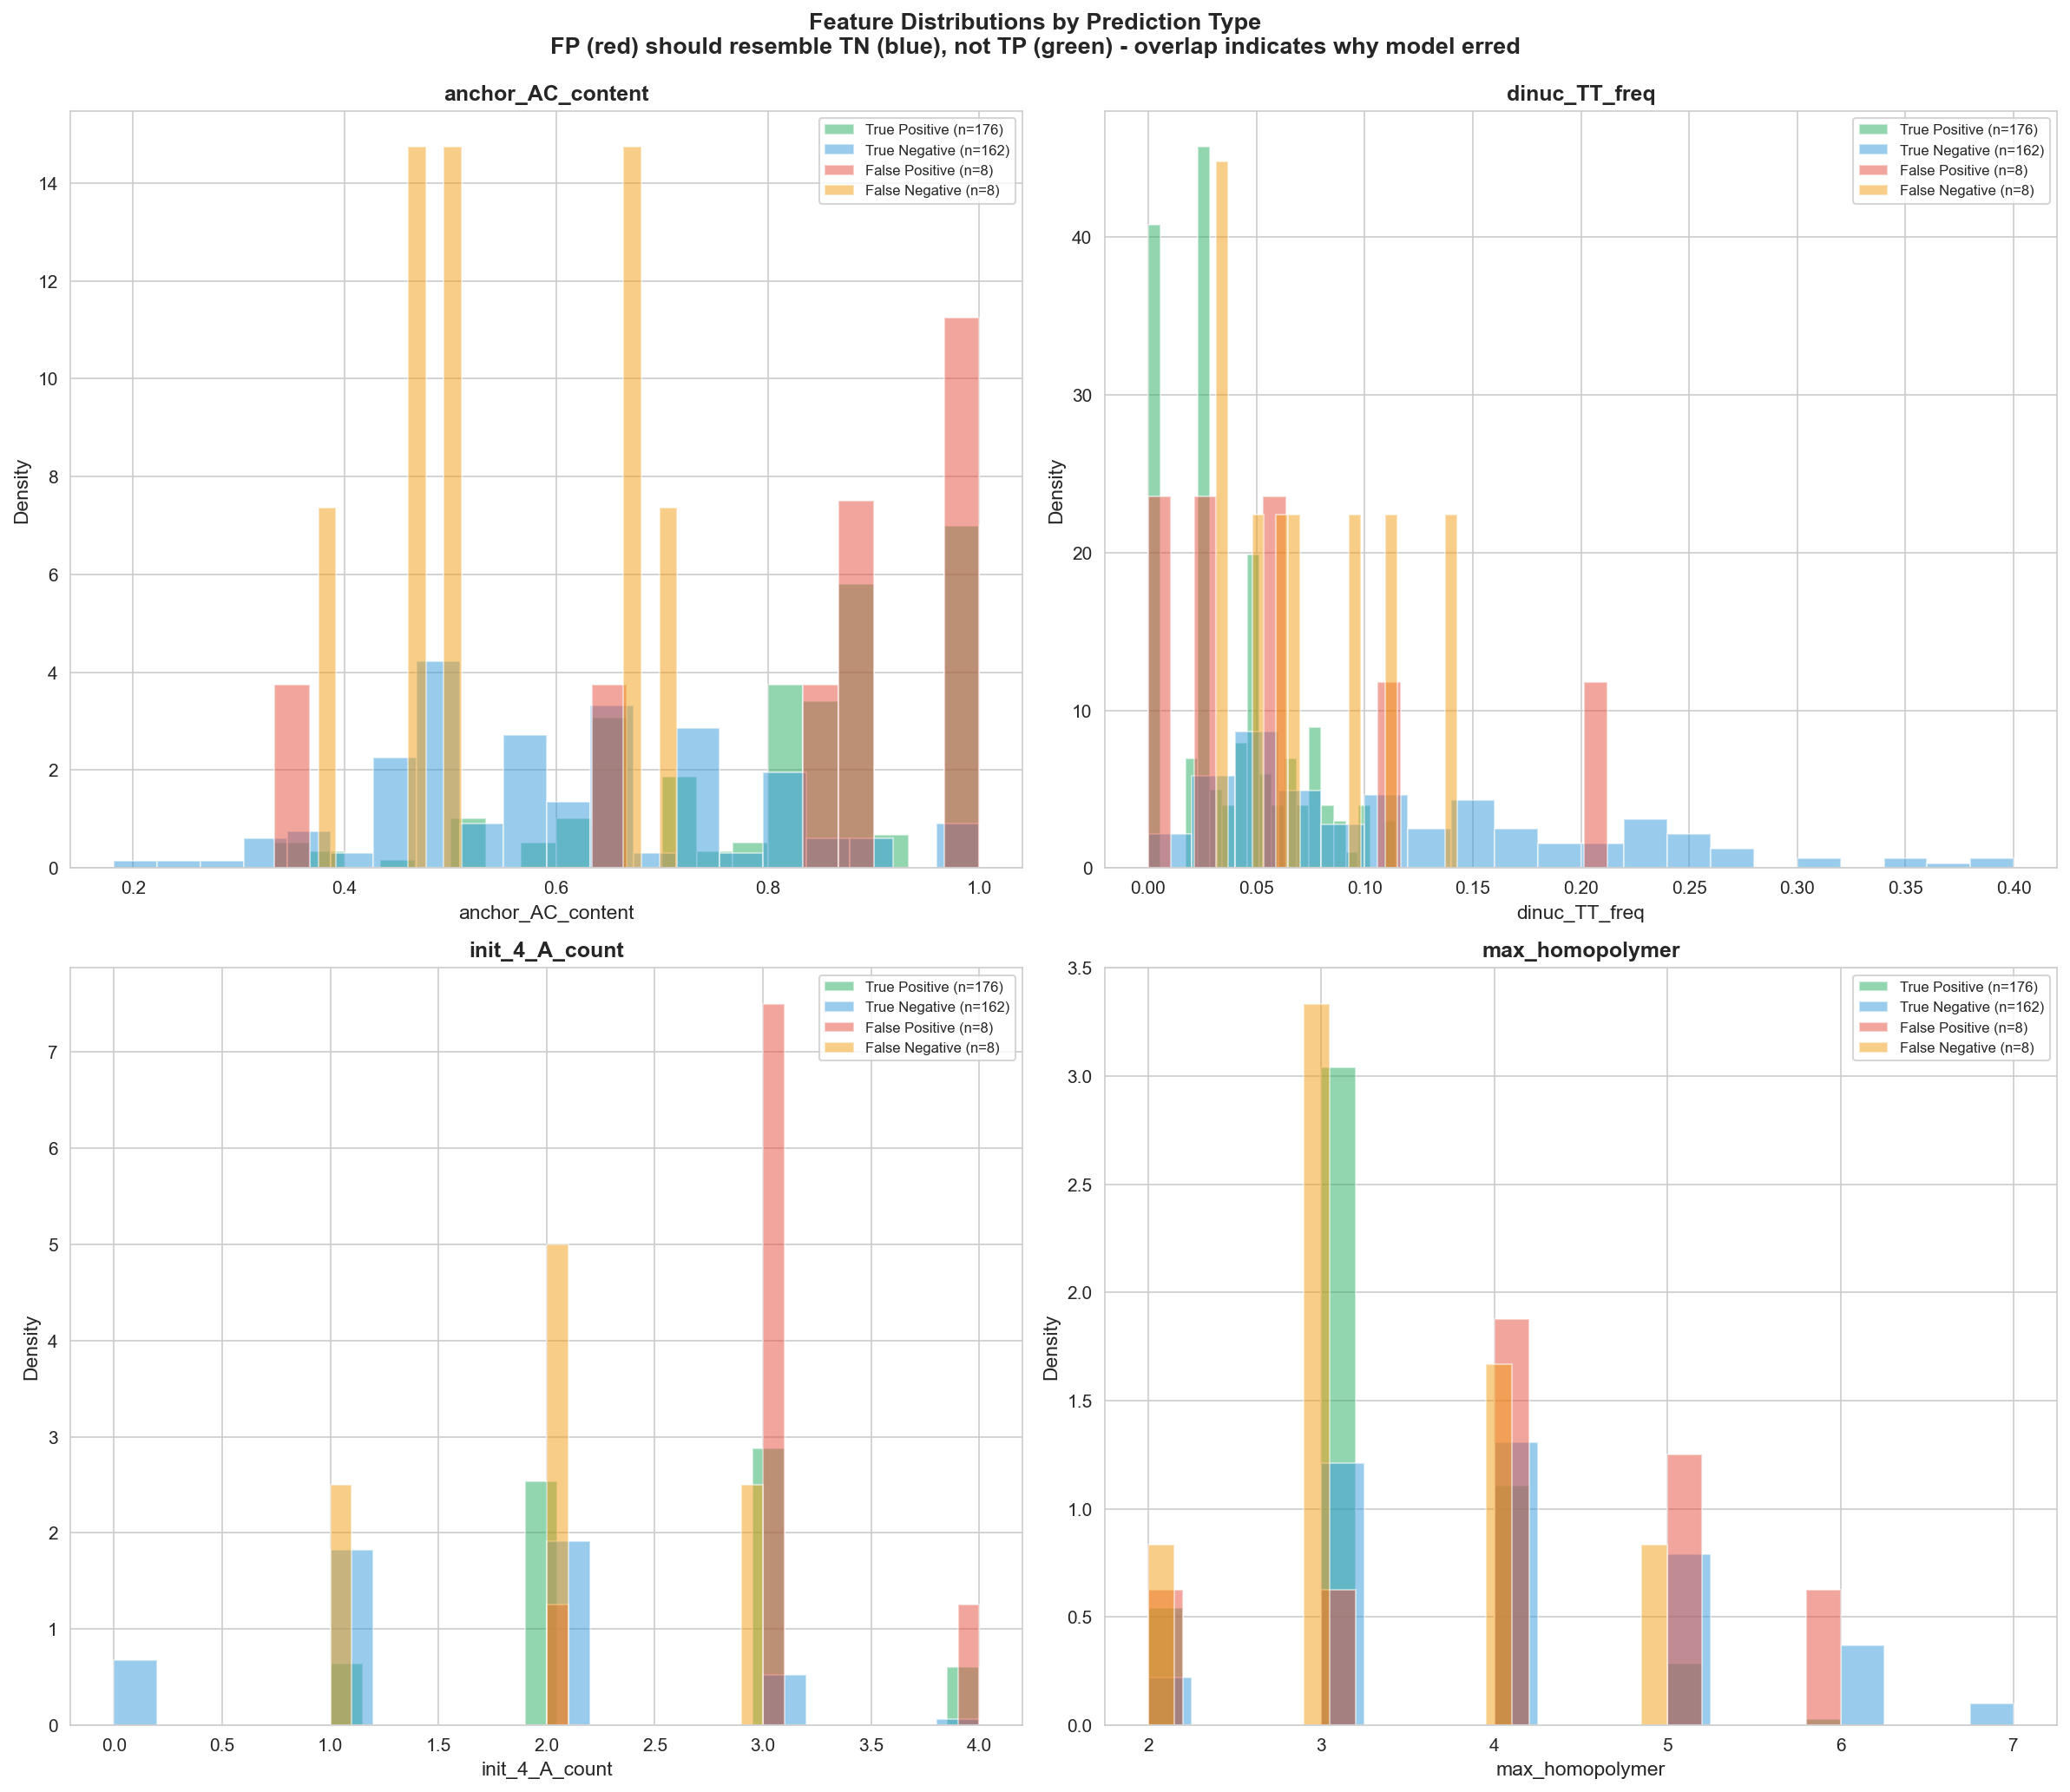

In [14]:
# =============================================================================
# VISUALIZATIONS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

colors = {
    'True Positive': '#27ae60', 
    'True Negative': '#3498db',
    'False Positive': '#e74c3c', 
    'False Negative': '#f39c12'
}

# 1. Feature distributions for key features
plot_features = ['anchor_AC_content', 'dinuc_TT_freq', 'init_4_A_count', 'max_homopolymer']
plot_features = [f for f in plot_features if f in feature_names][:4]

for idx, (ax, feat) in enumerate(zip(axes.flatten()[:len(plot_features)], plot_features)):
    for ptype, color in colors.items():
        subset = test_df[test_df['prediction_type'] == ptype][feat]
        if len(subset) > 0:
            ax.hist(subset, bins=20, alpha=0.5, label=f"{ptype} (n={len(subset)})", 
                   color=color, density=True)
    ax.set_xlabel(feat, fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(feat, fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)

plt.suptitle('Feature Distributions by Prediction Type\n'
             'FP (red) should resemble TN (blue), not TP (green) - overlap indicates why model erred\n',
             fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'error_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

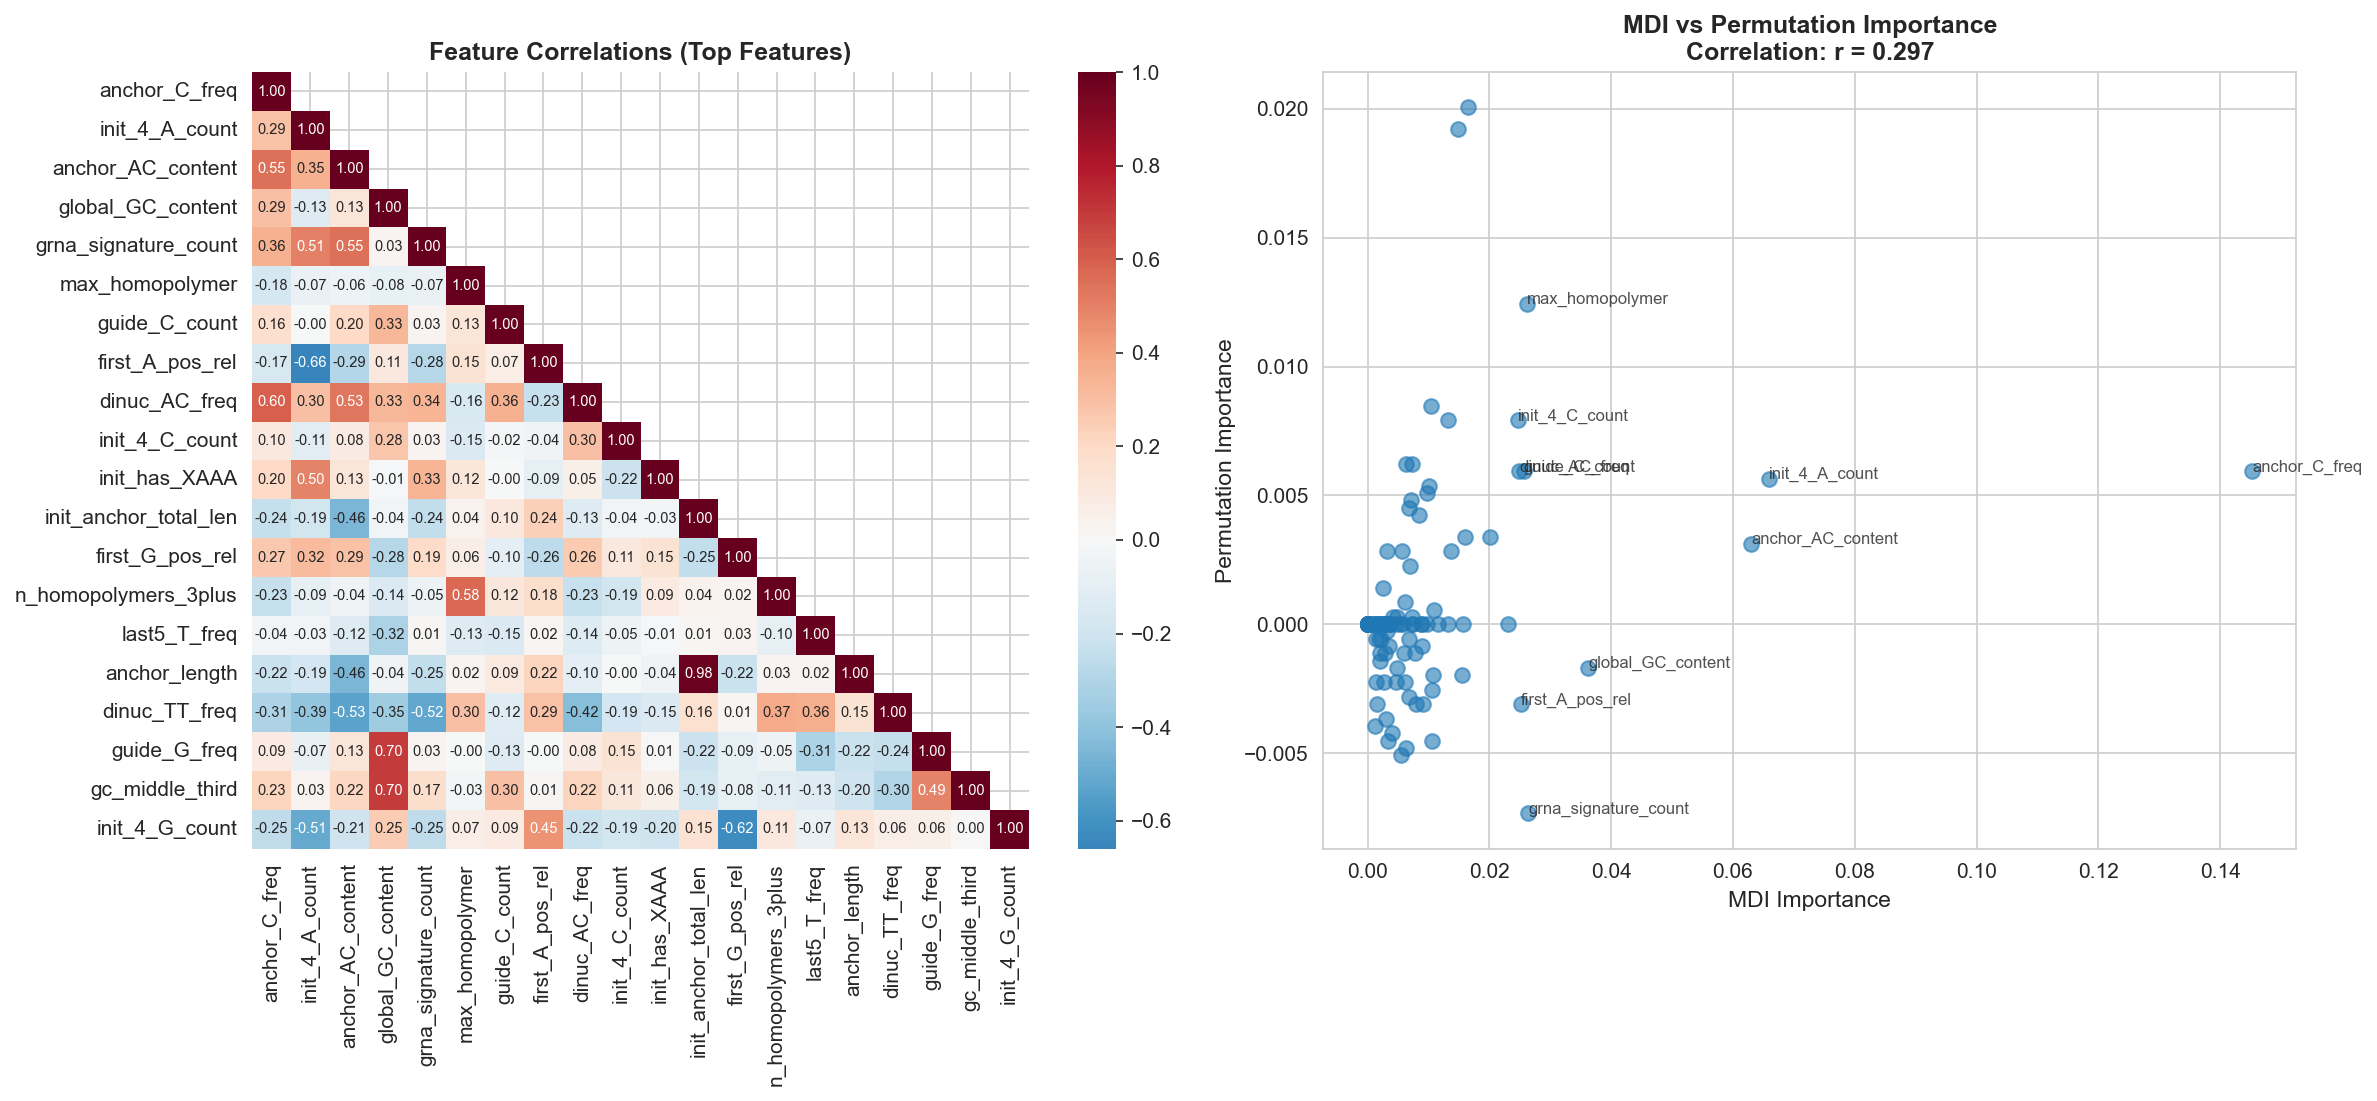

In [15]:
# MDI vs Permutation scatter + Correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Correlation heatmap
ax = axes[0]
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, ax=ax, annot_kws={'size': 7})
ax.set_title('Feature Correlations (Top Features)', fontsize=12, fontweight='bold')

# MDI vs Permutation scatter
ax = axes[1]
ax.scatter(importance_df['mdi'], importance_df['permutation'], alpha=0.6, s=50)

# Annotate top features
for _, row in importance_df.nlargest(10, 'mdi').iterrows():
    ax.annotate(row['feature'], (row['mdi'], row['permutation']), 
                fontsize=8, alpha=0.8)

ax.set_xlabel('MDI Importance', fontsize=11)
ax.set_ylabel('Permutation Importance', fontsize=11)

# Correlation
corr = importance_df['mdi'].corr(importance_df['permutation'])
ax.set_title(f'MDI vs Permutation Importance\nCorrelation: r = {corr:.3f}', 
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# =============================================================================
# SAVE RESULTS
# =============================================================================

print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save files
importance_df.to_csv(OUTPUT_DIR / 'importance_comparison.csv', index=False)
fp_df.to_csv(OUTPUT_DIR / 'false_positives.csv', index=False)
fn_df.to_csv(OUTPUT_DIR / 'false_negatives.csv', index=False)

print(f"\nFiles saved to {OUTPUT_DIR}:")
for f in sorted(OUTPUT_DIR.glob('*')):
    print(f"  {f.name}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)


SAVING RESULTS

Files saved to /Users/anna/projects/grna-inspector/data/processed/v4_pipeline/deep_analysis:
  error_feature_distributions.png
  false_negatives.csv
  false_positives.csv
  feature_comparison_fp_tp_tn.csv
  importance_comparison.csv
  importance_comparison.png
  rna_structure_analysis.csv
  structure_comparison.png
  structure_distributions.png

ANALYSIS COMPLETE
